In [2]:
import glob
import cv2
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid


from generate_finetuning_dataset import show_image_with_mask, load_gt_masks, load_bbox_coords, FINETUNE_DATASET_FOLDER, show_box, show_mask

/home/yoni/miniconda3/envs/reachbot/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


In [3]:
dataset_folder = "datasets/finetune"
target_class = "crack"

images_path = glob.glob(os.path.join(dataset_folder, target_class, "images", "*.png"))


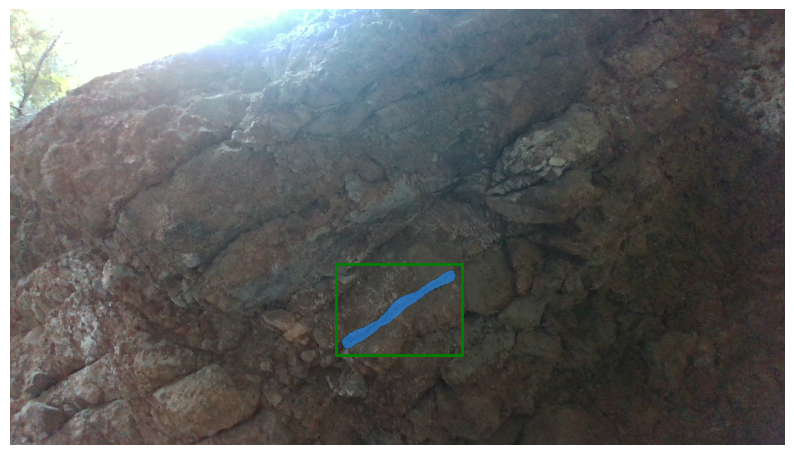

In [4]:
class_name = "crack"
gt_masks = load_gt_masks(class_name)
bbox_coords = load_bbox_coords(class_name)
show_image_with_mask(target_class, 121, bbox_coords, gt_masks)

In [5]:
def get_bboxes_for_mask(mask, max_size=30):
    non_zero_indices = np.nonzero(mask)
    x_min_idxs = (non_zero_indices[1] == non_zero_indices[1].min()).nonzero()[0]
    x_min_idx = x_min_idxs[np.argmin(non_zero_indices[0][x_min_idxs])]
    x_min = non_zero_indices[1][x_min_idx]
    y_min = non_zero_indices[0][x_min_idx]


    x_max_idx = np.argmax(non_zero_indices[1])
    x_global_max = non_zero_indices[1][x_max_idx]
    y_global_max_idx = np.argmax(non_zero_indices[0])
    y_global_max = non_zero_indices[0][y_global_max_idx]

    x_curr = x_min
    y_curr = y_min

    bboxes = []

    list_x = [x_curr]
    list_y = [y_curr]
    while x_curr < x_global_max and y_curr < y_global_max:
        if len(list_x)>= 2:
            if list_x[-1] - list_x[-2] > 0:
                max_x_diff =(non_zero_indices[1] - x_curr).max()
            else:
                max_x_diff =(non_zero_indices[1] - x_curr).min()

            if list_y[-1] - list_y[-2] > 0:
                max_y_diff =(non_zero_indices[0] - y_curr).max()
            else:
                max_y_diff =(non_zero_indices[0] - y_curr).min()
                
        else:
            max_x_diff_idx = np.argmax(abs(non_zero_indices[1] - x_curr))
            max_x_diff = abs(non_zero_indices[1][max_x_diff_idx] - x_curr)

            max_y_diff_idx = np.argmax(abs(non_zero_indices[0] - y_curr))
            max_y_diff = abs(non_zero_indices[0][max_y_diff_idx] - y_curr)

        if max_x_diff > max_size:
            # if y_global_max - y_curr > max_size:
            #     print("here1")
            #     new_x_curr_idx = np.where(non_zero_indices[1] == x_curr+max_size)
            #     new_y_curr_idx = np.where(non_zero_indices[0] == y_curr+max_size)
            #     break
            # else:
            if len(list_x)>= 2:
                if list_x[-1] - list_x[-2] > 0:
                    new_x_curr = x_curr+max_size
                else:
                    new_x_curr = x_curr-max_size
            elif non_zero_indices[1][max_x_diff_idx] - x_curr > 0:
                new_x_curr = x_curr+max_size
            else:
                new_x_curr = x_curr-max_size

            new_x_curr_idxs = (non_zero_indices[1] == new_x_curr).nonzero()[0]
            new_x_curr_idx_max = new_x_curr_idxs[np.argmax(abs(non_zero_indices[0][new_x_curr_idxs] - y_curr))]
            new_x_curr_idx_min = new_x_curr_idxs[np.argmin(abs(non_zero_indices[0][new_x_curr_idxs] - y_curr))]
            new_x_curr_max = non_zero_indices[1][new_x_curr_idx_max]
            new_y_curr_max = non_zero_indices[0][new_x_curr_idx_max]
            new_x_curr_min = non_zero_indices[1][new_x_curr_idx_min]
            new_y_curr_min = non_zero_indices[0][new_x_curr_idx_min]

            bboxes.append((x_curr, y_curr, new_x_curr_max, new_y_curr_max))
            x_curr = new_x_curr_min
            y_curr = new_y_curr_min

            list_x.append(x_curr)
            list_y.append(y_curr)

        elif max_y_diff > max_size:
            if len(list_y)>= 2:
                if list_y[-1] - list_y[-2] > 0:
                    new_y_curr = y_curr+max_size
                else:
                    new_y_curr = y_curr-max_size
            elif non_zero_indices[0][max_y_diff_idx] - y_curr > 0:
                new_y_curr = y_curr+max_size
            else:
                new_y_curr = y_curr-max_size

            new_y_curr_idxs = (non_zero_indices[0] == new_y_curr).nonzero()[0]
            new_y_curr_idx_max = new_y_curr_idxs[np.argmax(abs(non_zero_indices[1][new_y_curr_idxs] - x_curr))]
            new_y_curr_idx_min = new_y_curr_idxs[np.argmin(abs(non_zero_indices[1][new_y_curr_idxs] - x_curr))]

            new_x_curr_max = non_zero_indices[1][new_y_curr_idx_max]
            new_y_curr_max = non_zero_indices[0][new_y_curr_idx_max]
            new_x_curr_min = non_zero_indices[1][new_y_curr_idx_min]
            new_y_curr_min = non_zero_indices[0][new_y_curr_idx_min]

            bboxes.append((x_curr, y_curr, new_x_curr_max, new_y_curr_max))
            x_curr = new_x_curr_min
            y_curr = new_y_curr_min

            list_x.append(x_curr)
            list_y.append(y_curr)

        else:
            if len(list_x)>= 2:
                if list_x[-1] - list_x[-2] > 0:
                    x_global_max = non_zero_indices[1][np.argmax(non_zero_indices[1] - x_curr)]
                else:
                    x_global_max = non_zero_indices[1][np.argmin(non_zero_indices[1] - x_curr)]

                if list_y[-1] - list_y[-2] > 0:
                    y_global_max = non_zero_indices[0][np.argmax(non_zero_indices[0] - y_curr)]
                else:
                    y_global_max = non_zero_indices[0][np.argmin(non_zero_indices[0] - y_curr)]
            bboxes.append((x_curr, y_curr, x_global_max, y_global_max))
            break

    return bboxes

In [34]:
def get_square_bboxes(bboxes, mask, min_size=64, margin=0.2):
    square_bboxes = []
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        if x1 > x2:
            x1, x2 = x2, x1
        if y1 > y2:
            y1, y2 = y2, y1

        # transform the rectangle bboxes to square bboxes and add margins while considering the image boundary
        if x2 - x1 > y2 - y1:
            new_y1 = y1 - (x2 - x1 - (y2 - y1)) / 2
            new_y2 = y2 + (x2 - x1 - (y2 - y1)) / 2
            y1 = int(new_y1)
            y2 = int(new_y2)
        else:
            new_x1 = x1 - (y2 - y1 - (x2 - x1)) / 2
            new_x2 = x2 + (y2 - y1 - (x2 - x1)) / 2
            x1 = int(new_x1)
            x2 = int(new_x2)

        if x2 - x1 < min_size:
            continue
                
        x1 = x1 - int((x2 - x1) * margin)
        y1 = y1 - int((y2 - y1) * margin)
        x2 = x2 + int((x2 - x1) * margin)
        y2 = y2 + int((y2 - y1) * margin)

        
        
        # if the square bbox is out of the image boundary, then clip it and add padding to the other side to preserve the bbox size
        if x1 < 0:
            x2 = x2 - x1
            x1 = 0
        if y1 < 0:
            y2 = y2 - y1
            y1 = 0
        if x2 > mask.shape[1]:
            x1 = x1 - (x2 - mask.shape[1])
            x2 = mask.shape[1]
        if y2 > mask.shape[0]:
            y1 = y1 - (y2 - mask.shape[0])
            y2 = mask.shape[0]
        
        square_bboxes.append((x1, y1, x2, y2))
    
    return square_bboxes

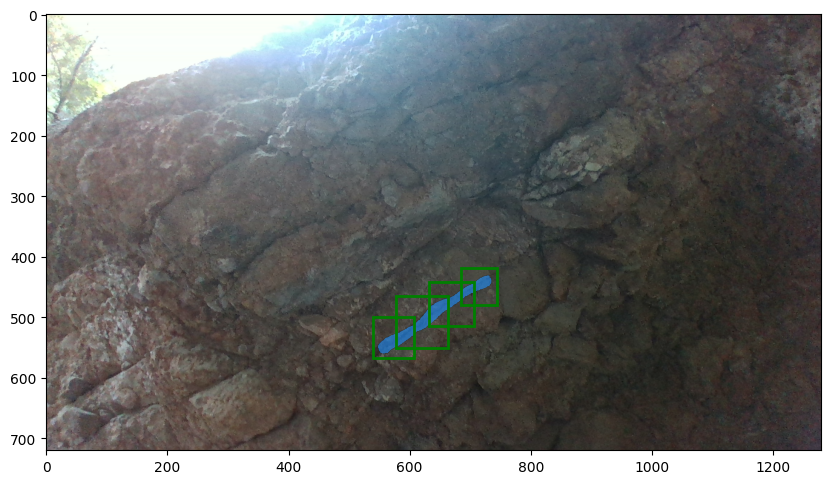

In [7]:
image_number = 121

image = cv2.imread(f"{FINETUNE_DATASET_FOLDER}/{class_name}/images/{image_number}.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
mask = gt_masks[image_number]
bboxes = get_bboxes_for_mask(mask, max_size=48)
square_bboxes = get_square_bboxes(bboxes, mask, min_size=32)
show_mask(mask, plt.gca())
for bbox in square_bboxes:
    show_box(bbox, plt.gca())
# plt.axis('off')
plt.show()

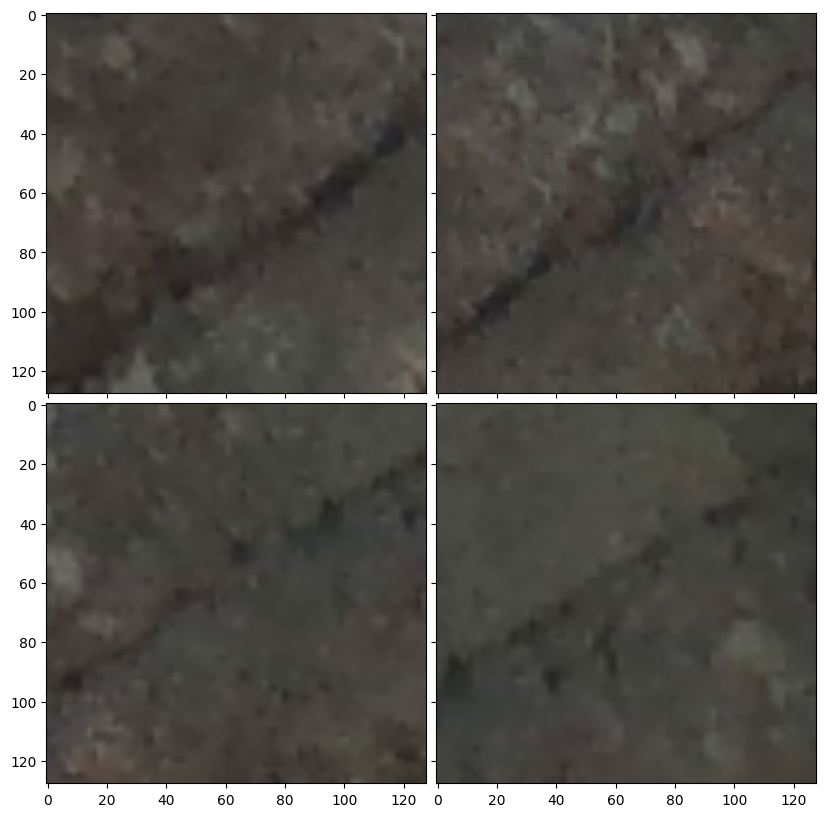

In [8]:

nb_bboxes = len(square_bboxes)
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(int(np.ceil(np.sqrt(nb_bboxes))), int(np.ceil(np.sqrt(nb_bboxes)))),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, bbox in zip(grid, square_bboxes):
    # Iterating over the grid returns the Axes.
    image_cropped = image[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    image_resized = cv2.resize(image_cropped, (128, 128))
    ax.imshow(image_resized)

plt.show()

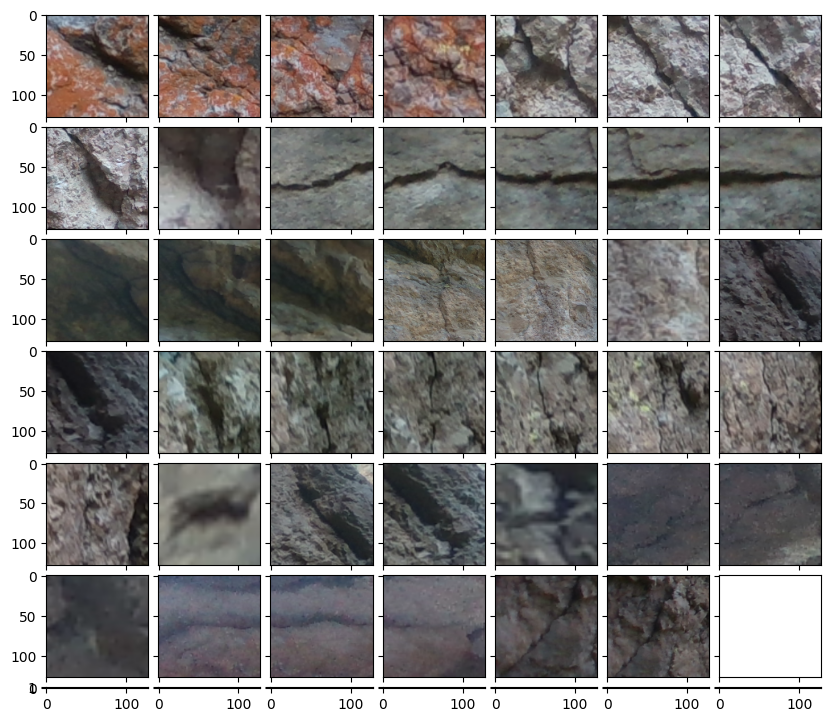

In [9]:
random_sampled_images_indexes = np.random.choice(len(bbox_coords), 16, replace=False)

images = []
for image_number in random_sampled_images_indexes:
    # Iterating over the grid returns the Axes.
    image = cv2.imread(f"{FINETUNE_DATASET_FOLDER}/{class_name}/images/{image_number}.png")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = gt_masks[image_number]
    bboxes = get_bboxes_for_mask(mask, max_size=64)
    square_bboxes = get_square_bboxes(bboxes, mask, min_size=32)
    for bbox in square_bboxes:
        image_cropped = image[bbox[1]:bbox[3], bbox[0]:bbox[2]]
        image_resized = cv2.resize(image_cropped, (128, 128))
        images.append(image_resized)

nb_images = len(images)
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(int(np.ceil(np.sqrt(nb_images))), int(np.ceil(np.sqrt(nb_images)))),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, image in zip(grid, images):
    ax.imshow(image)

plt.show()

In [10]:
def find_negative_samples(mask, mask_size, max_attempts = 10):
    nb_attempts = 0
    while nb_attempts < max_attempts:
        x = np.random.randint(0, mask.shape[1] - mask_size)
        y = np.random.randint(0, mask.shape[0] - mask_size)
        if np.sum(mask[y:y+mask_size, x:x+mask_size]) == 0:
            return x, y
        
        nb_attempts += 1
    
    return None, None

In [28]:
import configparser
from tqdm import tqdm

config = configparser.ConfigParser()
config.read("config.ini") # TODO: Fix config path and variables
CLASSES = ["edge", "boulder", "crack", "rough_patch"]
LABELBOX_DATASET_FOLDER = config["PATHS"]["LABELBOX_DATASET"]
FINETUNE_DATASET_FOLDER = config["PATHS"]["FINETUNE_DATASET"]
CRACKS_DATASET_FOLDER = config["PATHS"]["CRACKS_DATASET"]


def convert_mask_to_binary(mask: Image) -> Image:
    """Converts a mask to a binary mask."""
    mask = mask.convert("L")
    mask = mask.point(lambda x: 0 if x >= 128 else 255, '1')
    return mask

def generate_negative_samples(max_samples_per_image=10, mask_size=64):
    if not os.path.exists(CRACKS_DATASET_FOLDER):
        os.makedirs(os.path.join(CRACKS_DATASET_FOLDER, "train", "positive"))
        os.makedirs(os.path.join(CRACKS_DATASET_FOLDER, "train", "negative"))
        os.makedirs(os.path.join(CRACKS_DATASET_FOLDER, "test", "positive"))
        os.makedirs(os.path.join(CRACKS_DATASET_FOLDER, "test", "negative"))

    num_images = len(os.listdir(LABELBOX_DATASET_FOLDER))
    print(f"Found {num_images} images")

    nb_negative_samples = 0

    for i in tqdm(range(num_images)):
        img_folder = os.path.join(LABELBOX_DATASET_FOLDER, str(i))
        classes_file = os.path.join(img_folder, "classes.txt")

        # Get the classes
        with open(classes_file, "r") as f:
            classes = f.read().splitlines()

        mask_sum = None
        # Get the masks
        for j, class_mask in enumerate(classes):
            if class_mask == "crack":
                mask_path: str = os.path.join(img_folder, "mask_" + str(j) + ".png")
                original_mask: Image = Image.open(mask_path)
                original_mask = convert_mask_to_binary(original_mask)
                if mask_sum is None:
                    mask_sum = np.array(original_mask)
                else:
                    mask_sum += np.array(original_mask)
        img_path: str = os.path.join(img_folder, "image.png")
        img: Image = Image.open(img_path)
        if mask_sum is not None:
            mask = mask_sum.astype(np.uint8)
            for _ in range(max_samples_per_image):
                x, y = find_negative_samples(mask, mask_size)
                if x is not None:
                    img_cropped = img.crop((x, y, x+mask_size, y+mask_size))
                    img_cropped.save(os.path.join(CRACKS_DATASET_FOLDER, "train", "negative", f"{nb_negative_samples}.png"))
                    nb_negative_samples += 1
            
    


In [35]:
def generate_positive_samples(output_size=64, max_size=64, min_size=32):
    class_name = "crack"
    gt_masks = load_gt_masks(class_name)
    nb_positive_samples = 0
    for image_number in tqdm(range(len(gt_masks))):
        image = cv2.imread(f"{FINETUNE_DATASET_FOLDER}/{class_name}/images/{image_number}.png")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = gt_masks[image_number]
        bboxes = get_bboxes_for_mask(mask, max_size=max_size)
        square_bboxes = get_square_bboxes(bboxes, mask, min_size=min_size)
        for bbox in square_bboxes:
            image_cropped = image[bbox[1]:bbox[3], bbox[0]:bbox[2]]
            image_resized = cv2.resize(image_cropped, (output_size, output_size))
            cv2.imwrite(os.path.join(CRACKS_DATASET_FOLDER, "train", "positive", f"{nb_positive_samples}.png"), image_resized)
            nb_positive_samples += 1

In [36]:
generate_positive_samples(output_size=64)

100%|██████████| 561/561 [00:12<00:00, 45.74it/s]


In [29]:
generate_negative_samples()

Found 232 images


100%|██████████| 232/232 [00:05<00:00, 42.52it/s] 
